TRABAJO PRACTICO 3 - REDES NEURONALES - LUCAS PINI

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

import src.preprocessing as pre
import src.models as models
import src.metrics as metrics
import src.pytorchmodels as torchmodels 


1. ANÁLISIS Y PREPROCESAMIENTO DE DATOS

1.1 Cargo los datasets y observo si coinciden los tamaños con los de la consigna

In [2]:
X_images = np . load ("data\X_images.npy")
y_images = np . load ("data\y_images.npy")

print(f"Forma de X_images: {X_images.shape}")
print(f"Forma de y_images: {y_images.shape}")
print(f"Número de clases: {len(np.unique(y_images))}")

Forma de X_images: (809555, 28, 28)
Forma de y_images: (809555,)
Número de clases: 47


1.2 Visualizacion de imagenes

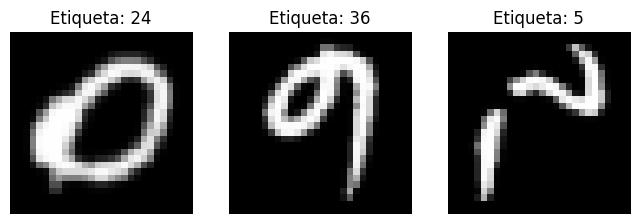

In [3]:

fig, axes = plt.subplots(1, 3, figsize=(8, 3))
for i, ax in enumerate(axes):
    img = X_images[i].reshape(28, 28)
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Etiqueta: {y_images[i]}")
    ax.axis("off")
plt.show()


Analisis la distribucion de las clases

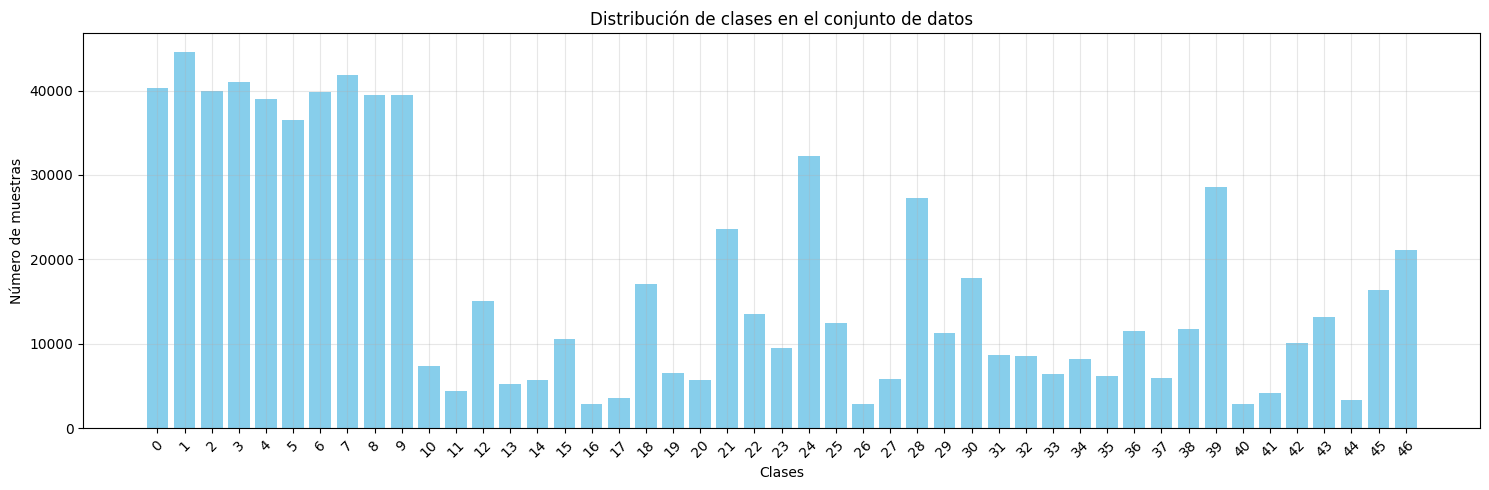

Número total de muestras: 809555
Número de clases: 47
Promedio de muestras por clase: 17224.6
Min muestras por clase: 2861 (clase 40)
Max muestras por clase: 44604 (clase 1)


In [ ]:
plt.figure(figsize=(15, 5))
classes, counts = np.unique(y_images, return_counts=True)
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Clases')
plt.ylabel('Número de muestras')
plt.title('Distribución de clases en el conjunto de datos')
plt.xticks(classes, rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Número total de muestras: {len(y_images)}")
print(f"Número de clases: {len(classes)}")
print(f"Promedio de muestras por clase: {counts.mean():.1f}")
print(f"Min muestras por clase: {counts.min()} (clase {classes[counts.argmin()]})")
print(f"Max muestras por clase: {counts.max()} (clase {classes[counts.argmax()]})")


Las clases correspondientes a los digitos del 0 al 9 estan significativamente sobrevalanceadas. Por ende aplico undersampling para las clases mayoritarias sin igualar a las clases minoritarias para tampoco perder toda la información.

1.3 Divido el dataset en Train, Validation y Test

In [5]:
X_train, y_train, X_val, y_val, X_test, y_test = pre.split_dataset(X_images, y_images)

print(f"Tamaño de Train: {X_train.shape[0]}")
print(f"Tamaño de Validation: {X_val.shape[0]}")
print(f"Tamaño de Test: {X_test.shape[0]}")

Tamaño de Train: 647644
Tamaño de Validation: 80955
Tamaño de Test: 80956


In [ ]:
# Aplico Undersampling solo al conjunto de train
X_train_bal, y_train_bal = pre.undersample_partial(X_train, y_train, factor=0.5)

print("Antes del undersampling:")
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

print("\nDespués del undersampling parcial:")
unique, counts = np.unique(y_train_bal, return_counts=True)
print(dict(zip(unique, counts)))


Tamaño objetivo aproximado por clase: 18933
Distribución de clases luego del undersampling parcial:
Clase  0: 18933 muestras
Clase  1: 18933 muestras
Clase  2: 18933 muestras
Clase  3: 18933 muestras
Clase  4: 18933 muestras
Clase  5: 18933 muestras
Clase  6: 18933 muestras
Clase  7: 18933 muestras
Clase  8: 18933 muestras
Clase  9: 18933 muestras
Clase 10: 5931 muestras
Clase 11: 3525 muestras
Clase 12: 12021 muestras
Clase 13: 4195 muestras
Clase 14: 4513 muestras
Clase 15: 8377 muestras
Clase 16: 2272 muestras
Clase 17: 2838 muestras
Clase 18: 13691 muestras
Clase 19: 5161 muestras
Clase 20: 4576 muestras
Clase 21: 18933 muestras
Clase 22: 10810 muestras
Clase 23: 7613 muestras
Clase 24: 18933 muestras
Clase 25: 9977 muestras
Clase 26: 2328 muestras
Clase 27: 4631 muestras
Clase 28: 18933 muestras
Clase 29: 9111 muestras
Clase 30: 14233 muestras
Clase 31: 6992 muestras
Clase 32: 6849 muestras
Clase 33: 5154 muestras
Clase 34: 6524 muestras
Clase 35: 5017 muestras
Clase 36: 9226 mues

1.4 Normalización de los datos dividiendo por 255 y hago one-hot

In [7]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

print(f"Rango de X_train: {X_train.min():.3f} - {X_train.max():.3f}")

num_classes = len(np.unique(y_train))

X_train_flat = X_train.reshape(X_train.shape[0], -1).T
X_val_flat   = X_val.reshape(X_val.shape[0], -1).T
X_test_flat  = X_test.reshape(X_test.shape[0], -1).T

Y_train_oh = pre.one_hot(y_train, num_classes)
Y_val_oh   = pre.one_hot(y_val, num_classes)
Y_test_oh  = pre.one_hot(y_test, num_classes)



Rango de X_train: 0.000 - 1.000


2. Entrenamiento de una Red Neuronal con:

- 2 capas ocultas

- 128 y 64 neuronas

- ReLU en ocultas y Softmax en salida

- Función de costo: Cross-Entropy

- Entrenamiento con gradiente descendente

- Inicialización de parametros con He inicialization como recomienda el Bishop y biases en 0

2.1 Defino y Entreno el modelo basico M0

In [ ]:
dims = [784, 128, 64, num_classes]  # 2 capas ocultas

time_0 = time.time()
parametros_M0, losses_train, losses_val = models.entrenar_red_con_validacion(
    X_train_flat, Y_train_oh, X_val_flat, Y_val_oh,
    dims, epochs=20, lr=0.1 , batch_size=2000 # Uso de batching
)
time_1 = time.time()
print(f"Tiempo de entrenamiento M0: {time_1 - time_0:.2f} segundos")


Época 1/20 | Loss Train: 4.0217 | Loss Val: 3.8671
Época 2/20 | Loss Train: 3.8660 | Loss Val: 3.7868
Época 3/20 | Loss Train: 3.7862 | Loss Val: 3.7240
Época 4/20 | Loss Train: 3.7236 | Loss Val: 3.6693
Época 5/20 | Loss Train: 3.6691 | Loss Val: 3.6195
Época 6/20 | Loss Train: 3.6194 | Loss Val: 3.5719
Época 7/20 | Loss Train: 3.5719 | Loss Val: 3.5249
Época 8/20 | Loss Train: 3.5250 | Loss Val: 3.4776
Época 9/20 | Loss Train: 3.4779 | Loss Val: 3.4302
Época 10/20 | Loss Train: 3.4306 | Loss Val: 3.3827
Época 11/20 | Loss Train: 3.3835 | Loss Val: 3.3354
Época 12/20 | Loss Train: 3.3365 | Loss Val: 3.2884
Época 13/20 | Loss Train: 3.2898 | Loss Val: 3.2418
Época 14/20 | Loss Train: 3.2435 | Loss Val: 3.1957
Época 15/20 | Loss Train: 3.1977 | Loss Val: 3.1501
Época 16/20 | Loss Train: 3.1526 | Loss Val: 3.1052
Época 17/20 | Loss Train: 3.1081 | Loss Val: 3.0611
Época 18/20 | Loss Train: 3.0643 | Loss Val: 3.0176
Época 19/20 | Loss Train: 3.0212 | Loss Val: 2.9748
Época 20/20 | Loss Tr

Con el fin de evitar cargar matrices enormes en memoria se utilizo Batching en estos primeros modelos. Ya que por limitación de hardware se hacia imposible cargar el full batch. De esta forma proceso cada bloque por separado y acumulo los gradientes. Matematicamente obtengo el mismo resultado pero no sobrecargo la memoria RAM.

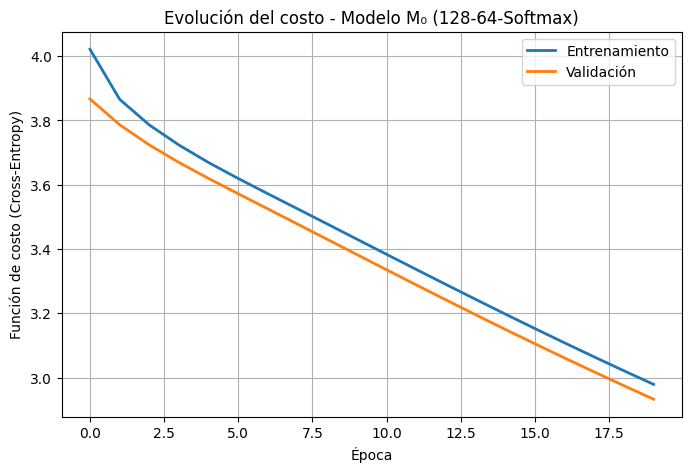

In [9]:
losses_train_m0 = losses_train
losses_val_m0   = losses_val

plt.figure(figsize=(8, 5))
plt.plot(losses_train, label="Entrenamiento", linewidth=2)
plt.plot(losses_val, label="Validación", linewidth=2)
plt.xlabel("Época")
plt.ylabel("Función de costo (Cross-Entropy)")
plt.title("Evolución del costo - Modelo M₀ (128-64-Softmax)")
plt.legend()
plt.grid(True)
plt.show()


2.2 Reporte de Metricas

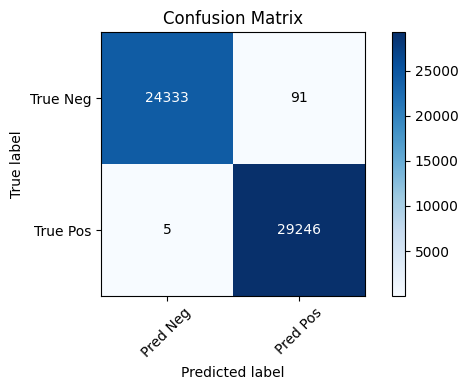

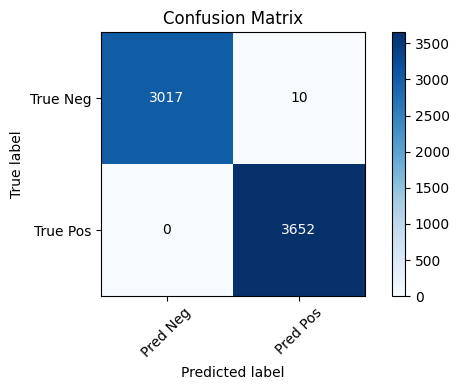

Entrenamiento:
  Accuracy:       0.3346
  Cross-Entropy:  2.9373
  F1-Score Macro: 0.1101

Validación:
  Accuracy:       0.3388
  Cross-Entropy:  2.9327
  F1-Score Macro: 0.1110


In [10]:
metricas_M0 = metrics.metrics_report(
    X_train_flat, Y_train_oh, y_train,
    X_val_flat, Y_val_oh, y_val,
    parametros_M0, num_classes
)


En principio las metricas no parecen reflejar un buen funcionamiento del modelo. Para comparar veo como se comporta un modelo mas Avanzado que llamo M1.

3. Implementación y Entrenamiento de una Red Neuronal Avanzada (M1)

3.1 Rate scheduling lineal (con saturación) y exponencial

In [11]:
# Parámetros base del modelo M0
dims = [784, 128, 64, num_classes]

import time

t0 = time.time()
# --- Lineal con saturación ---
param_M1_lin, loss_tr_lin, loss_val_lin, lrs_lin = models.entrenar_red_con_validacion_scheduler(
    X_train_flat, Y_train_oh, X_val_flat, Y_val_oh,
    dims=dims,
    epochs=20,
    lr_init=0.01,
    lr_final=0.001,
    scheduler="linear"
)
t1 = time.time()


print(f"Tiempo de entrenamiento M1 (Linieal): {t1 - t0:.2f} segundos")

t2 = time.time()
# --- Exponencial ---
param_M1_exp, loss_tr_exp, loss_val_exp, lrs_exp = models.entrenar_red_con_validacion_scheduler(
    X_train_flat, Y_train_oh, X_val_flat, Y_val_oh,
    dims=dims,
    epochs=20,
    lr_init=0.01,
    decay_rate=0.05,
    scheduler="exponential"
)
t3 = time.time()

print(f"Tiempo de entrenamiento M1 (Exponencial): {t1 - t0:.2f} segundos")


Época 1/20 | Loss Train: 4.0217 | Loss Val: 4.0045
Época 2/20 | Loss Train: 4.0026 | Loss Val: 3.9875
Época 3/20 | Loss Train: 3.9858 | Loss Val: 3.9725
Época 4/20 | Loss Train: 3.9708 | Loss Val: 3.9592
Época 5/20 | Loss Train: 3.9576 | Loss Val: 3.9473
Época 6/20 | Loss Train: 3.9457 | Loss Val: 3.9365
Época 7/20 | Loss Train: 3.9350 | Loss Val: 3.9269
Época 8/20 | Loss Train: 3.9254 | Loss Val: 3.9183
Época 9/20 | Loss Train: 3.9168 | Loss Val: 3.9104
Época 10/20 | Loss Train: 3.9090 | Loss Val: 3.9034
Época 11/20 | Loss Train: 3.9021 | Loss Val: 3.8971
Época 12/20 | Loss Train: 3.8958 | Loss Val: 3.8914
Época 13/20 | Loss Train: 3.8902 | Loss Val: 3.8864
Época 14/20 | Loss Train: 3.8851 | Loss Val: 3.8819
Época 15/20 | Loss Train: 3.8807 | Loss Val: 3.8780
Época 16/20 | Loss Train: 3.8769 | Loss Val: 3.8746
Época 17/20 | Loss Train: 3.8735 | Loss Val: 3.8717
Época 18/20 | Loss Train: 3.8706 | Loss Val: 3.8694
Época 19/20 | Loss Train: 3.8683 | Loss Val: 3.8674
Época 20/20 | Loss Tr

Visualización de resultados:

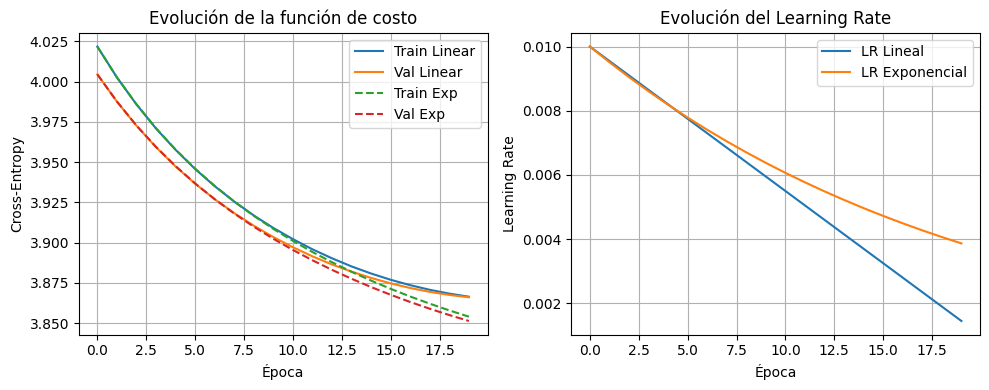

In [12]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(loss_tr_lin, label="Train Linear")
plt.plot(loss_val_lin, label="Val Linear")
plt.plot(loss_tr_exp, label="Train Exp", linestyle='--')
plt.plot(loss_val_exp, label="Val Exp", linestyle='--')
plt.xlabel("Época")
plt.ylabel("Cross-Entropy")
plt.title("Evolución de la función de costo")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(lrs_lin, label="LR Lineal")
plt.plot(lrs_exp, label="LR Exponencial")
plt.xlabel("Época")
plt.ylabel("Learning Rate")
plt.title("Evolución del Learning Rate")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Métricas Modelo M1 - LR Lineal


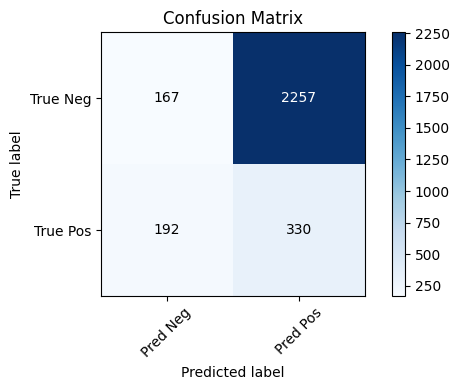

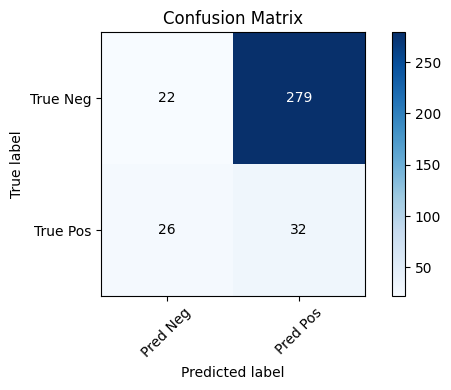

Entrenamiento:
  Accuracy:       0.0204
  Cross-Entropy:  3.8649
  F1-Score Macro: 0.0093

Validación:
  Accuracy:       0.0201
  Cross-Entropy:  3.8660
  F1-Score Macro: 0.0094

Métricas Modelo M1 - LR Exponencial


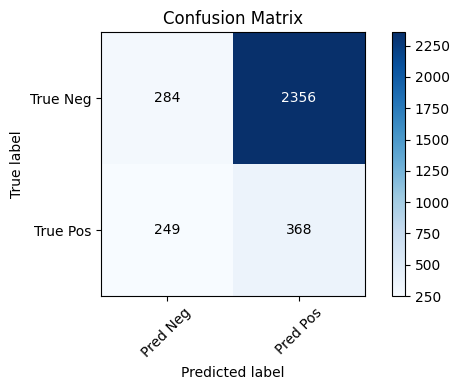

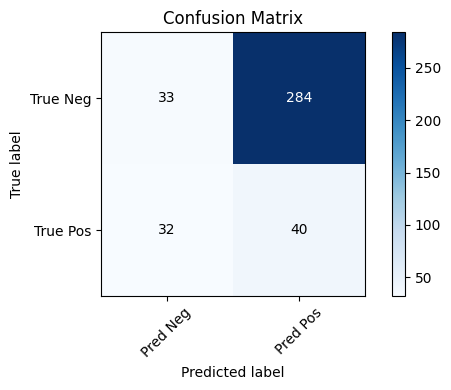

Entrenamiento:
  Accuracy:       0.0237
  Cross-Entropy:  3.8503
  F1-Score Macro: 0.0107

Validación:
  Accuracy:       0.0241
  Cross-Entropy:  3.8513
  F1-Score Macro: 0.0112


In [37]:
print("Métricas Modelo M1 - LR Lineal")
metrics_m1 = metrics.metrics_report(
    X_train_flat, Y_train_oh, y_train,
    X_val_flat, Y_val_oh, y_val,
    param_M1_lin, num_classes
)
print("\nMétricas Modelo M1 - LR Exponencial")
metrics_m1 = metrics.metrics_report(
    X_train_flat, Y_train_oh, y_train,
    X_val_flat, Y_val_oh, y_val,
    param_M1_exp, num_classes
)


3.2 Mini-batch stochastic gradient descent

In [14]:
dims = [784, 128, 64, num_classes]

param_Mopt, loss_tr_sgd, loss_val_sgd = models.entrenar_red_minibatch_optimizado(
    X_train_flat, Y_train_oh,
    X_val_flat, Y_val_oh,
    dims=dims,
    epochs=20,
    lr=0.2,
    batch_size=512,   # probá 256–1024 según tu RAM
    verbose=True,
    val_interval=1
)

Época 1/20 | Loss Train: 0.8630 | Loss Val: 0.5638
Época 2/20 | Loss Train: 0.5245 | Loss Val: 0.4665
Época 3/20 | Loss Train: 0.4594 | Loss Val: 0.4292
Época 4/20 | Loss Train: 0.4268 | Loss Val: 0.4155
Época 5/20 | Loss Train: 0.4055 | Loss Val: 0.3974
Época 6/20 | Loss Train: 0.3912 | Loss Val: 0.3901
Época 7/20 | Loss Train: 0.3802 | Loss Val: 0.3752
Época 8/20 | Loss Train: 0.3717 | Loss Val: 0.3744
Época 9/20 | Loss Train: 0.3639 | Loss Val: 0.3741
Época 10/20 | Loss Train: 0.3577 | Loss Val: 0.3661
Época 11/20 | Loss Train: 0.3522 | Loss Val: 0.3648
Época 12/20 | Loss Train: 0.3474 | Loss Val: 0.3589
Época 13/20 | Loss Train: 0.3436 | Loss Val: 0.3595
Época 14/20 | Loss Train: 0.3397 | Loss Val: 0.3527
Época 15/20 | Loss Train: 0.3361 | Loss Val: 0.3514
Época 16/20 | Loss Train: 0.3329 | Loss Val: 0.3523
Época 17/20 | Loss Train: 0.3302 | Loss Val: 0.3587
Época 18/20 | Loss Train: 0.3277 | Loss Val: 0.3458
Época 19/20 | Loss Train: 0.3252 | Loss Val: 0.3400
Época 20/20 | Loss Tr

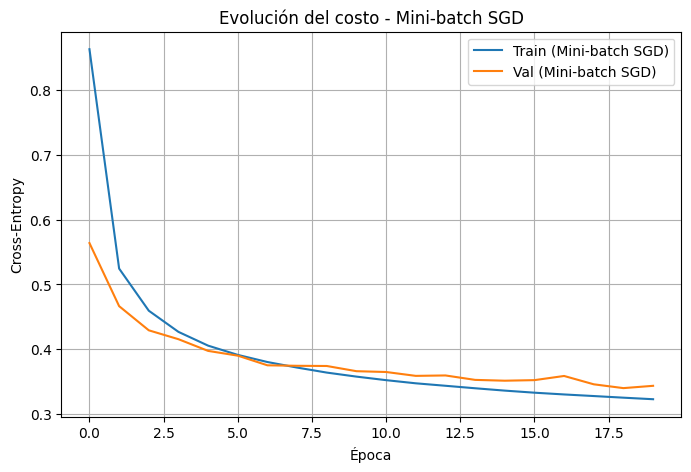

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(loss_tr_sgd, label="Train (Mini-batch SGD)")
plt.plot(loss_val_sgd, label="Val (Mini-batch SGD)")
plt.xlabel("Época")
plt.ylabel("Cross-Entropy")
plt.title("Evolución del costo - Mini-batch SGD")
plt.legend()
plt.grid(True)
plt.show()


Reporte de metricas:

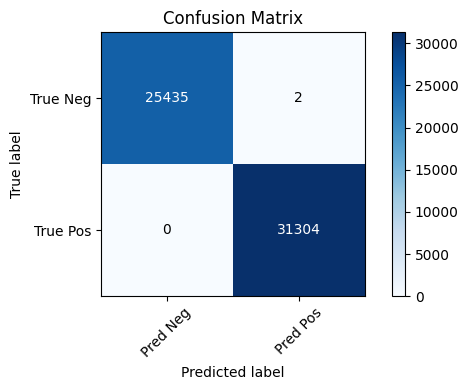

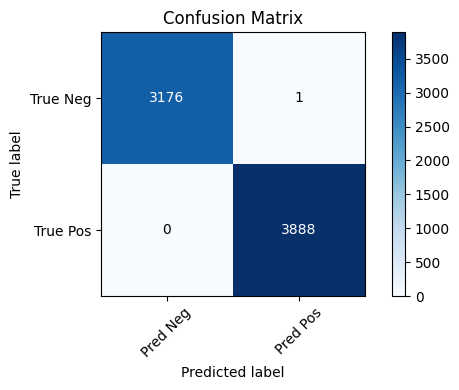

Entrenamiento:
  Accuracy:       0.8879
  Cross-Entropy:  0.3152
  F1-Score Macro: 0.8616

Validación:
  Accuracy:       0.8801
  Cross-Entropy:  0.3435
  F1-Score Macro: 0.8457


In [16]:
metricas_sgd = metrics.metrics_report(
    X_train_flat, Y_train_oh, y_train,
    X_val_flat, Y_val_oh, y_val,
    param_Mopt, num_classes
)

3.3 Optimizador Adam.

In [17]:
dims = [784, 128, 64, num_classes]

param_adam, loss_tr_adam, loss_val_adam = models.entrenar_red_adam(
    X_train_flat, Y_train_oh,
    X_val_flat, Y_val_oh,
    dims=dims,
    epochs=20,
    lr=0.001,         # Adam usa lr más bajo
    batch_size=512,   # más grande = más estable
    verbose=True,
    val_interval=1
)


Época 1/20 | Loss Train: 0.8120 | Loss Val: 0.5976
Época 2/20 | Loss Train: 0.5665 | Loss Val: 0.5257
Época 3/20 | Loss Train: 0.5158 | Loss Val: 0.4925
Época 4/20 | Loss Train: 0.4876 | Loss Val: 0.4736
Época 5/20 | Loss Train: 0.4679 | Loss Val: 0.4555
Época 6/20 | Loss Train: 0.4530 | Loss Val: 0.4439
Época 7/20 | Loss Train: 0.4411 | Loss Val: 0.4353
Época 8/20 | Loss Train: 0.4315 | Loss Val: 0.4278
Época 9/20 | Loss Train: 0.4233 | Loss Val: 0.4205
Época 10/20 | Loss Train: 0.4161 | Loss Val: 0.4169
Época 11/20 | Loss Train: 0.4099 | Loss Val: 0.4110
Época 12/20 | Loss Train: 0.4041 | Loss Val: 0.4057
Época 13/20 | Loss Train: 0.3991 | Loss Val: 0.4014
Época 14/20 | Loss Train: 0.3944 | Loss Val: 0.3978
Época 15/20 | Loss Train: 0.3903 | Loss Val: 0.3961
Época 16/20 | Loss Train: 0.3863 | Loss Val: 0.3939
Época 17/20 | Loss Train: 0.3825 | Loss Val: 0.3897
Época 18/20 | Loss Train: 0.3794 | Loss Val: 0.3877
Época 19/20 | Loss Train: 0.3760 | Loss Val: 0.3852
Época 20/20 | Loss Tr

Reporte de metricas:

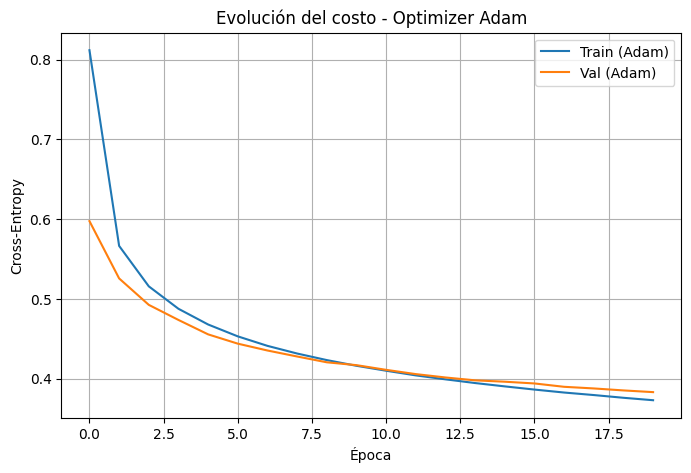

In [18]:
plt.figure(figsize=(8,5))
plt.plot(loss_tr_adam, label="Train (Adam)")
plt.plot(loss_val_adam, label="Val (Adam)")
plt.xlabel("Época")
plt.ylabel("Cross-Entropy")
plt.title("Evolución del costo - Optimizer Adam")
plt.legend()
plt.grid(True)
plt.show()


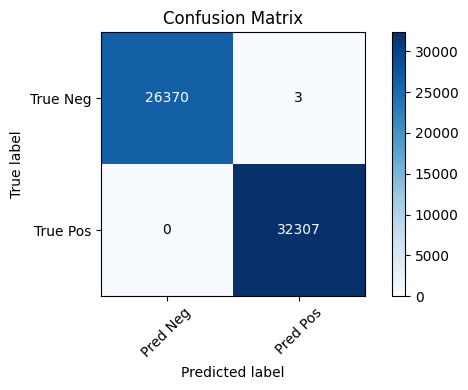

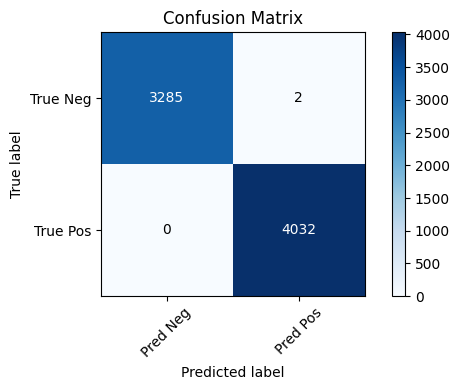

Entrenamiento:
  Accuracy:       0.8747
  Cross-Entropy:  0.3680
  F1-Score Macro: 0.8380

Validación:
  Accuracy:       0.8699
  Cross-Entropy:  0.3830
  F1-Score Macro: 0.8278


In [19]:
metricas_adam =metrics.metrics_report(
    X_train_flat, Y_train_oh, y_train,
    X_val_flat, Y_val_oh, y_val,
    param_adam, num_classes
)

3.4 Regularización (L2, Early Stopping)

In [20]:
dims = [784, 128, 64, num_classes]

param_reg, loss_tr_reg, loss_val_reg = models.entrenar_red_adam_regularizado(
    X_train_flat, Y_train_oh,
    X_val_flat, Y_val_oh,
    dims=dims,
    epochs=20,
    lr=0.001,
    batch_size=512,
    lambda_l2=1e-4,
    patience=5,
    val_interval=1,
    verbose=True
)


Época 1/50 | Train: 0.8120 | Val: 0.5976
Época 2/50 | Train: 0.5663 | Val: 0.5248
Época 3/50 | Train: 0.5147 | Val: 0.4912
Época 4/50 | Train: 0.4864 | Val: 0.4724
Época 5/50 | Train: 0.4669 | Val: 0.4540
Época 6/50 | Train: 0.4524 | Val: 0.4428
Época 7/50 | Train: 0.4406 | Val: 0.4346
Época 8/50 | Train: 0.4312 | Val: 0.4270
Época 9/50 | Train: 0.4230 | Val: 0.4200
Época 10/50 | Train: 0.4159 | Val: 0.4161
Época 11/50 | Train: 0.4098 | Val: 0.4100
Época 12/50 | Train: 0.4038 | Val: 0.4044
Época 13/50 | Train: 0.3988 | Val: 0.4001
Época 14/50 | Train: 0.3940 | Val: 0.3966
Época 15/50 | Train: 0.3898 | Val: 0.3948
Época 16/50 | Train: 0.3857 | Val: 0.3918
Época 17/50 | Train: 0.3819 | Val: 0.3879
Época 18/50 | Train: 0.3787 | Val: 0.3858
Época 19/50 | Train: 0.3753 | Val: 0.3828
Época 20/50 | Train: 0.3723 | Val: 0.3804
Época 21/50 | Train: 0.3693 | Val: 0.3786
Época 22/50 | Train: 0.3668 | Val: 0.3763
Época 23/50 | Train: 0.3641 | Val: 0.3747
Época 24/50 | Train: 0.3616 | Val: 0.3730
É

Reporte de metricas:

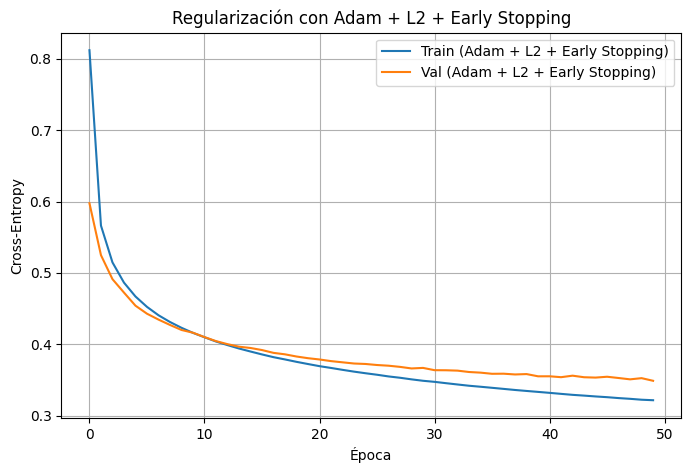

In [21]:
plt.figure(figsize=(8,5))
plt.plot(loss_tr_reg, label="Train (Adam + L2 + Early Stopping)")
plt.plot(loss_val_reg, label="Val (Adam + L2 + Early Stopping)")
plt.xlabel("Época")
plt.ylabel("Cross-Entropy")
plt.title("Regularización con Adam + L2 + Early Stopping")
plt.legend()
plt.grid(True)
plt.show()


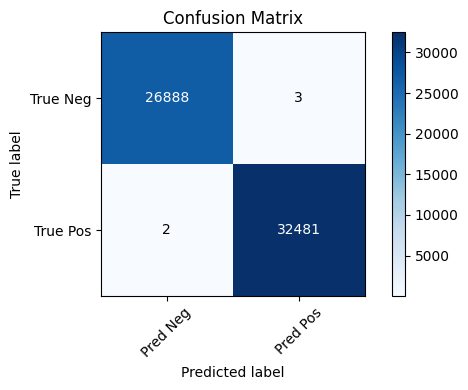

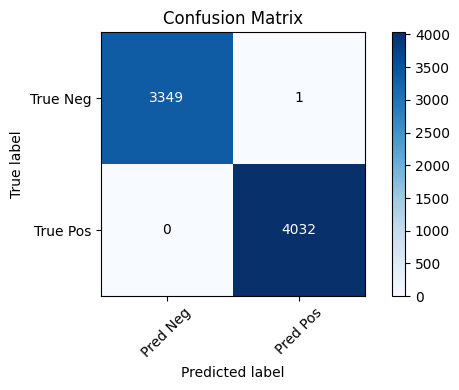

Entrenamiento:
  Accuracy:       0.8890
  Cross-Entropy:  0.3154
  F1-Score Macro: 0.8604

Validación:
  Accuracy:       0.8794
  Cross-Entropy:  0.3488
  F1-Score Macro: 0.8419


In [22]:
metrics_L2_earlystopping = metrics.metrics_report(
    X_train_flat, Y_train_oh, y_train,
    X_val_flat, Y_val_oh, y_val,
    param_reg, num_classes
)

3.5 Exploracion de Arquitecturas y Combinaciones de Distintos Modelos 

In [ ]:
import numpy as np
import pandas as pd
import time

# Aarmo un subset para acelerar la búsqueda
subset = 100_000
X_train_sub = X_train_flat[:, :subset]
Y_train_sub = Y_train_oh[:, :subset]
y_train_sub = y_train[:subset]
X_val_sub = X_val_flat[:, :subset//5]
Y_val_sub = Y_val_oh[:, :subset//5]
y_val_sub = y_val[:subset//5]

# HIPERPARÁMETROS A EXPLORAR 
architectures = [
    [128, 64],
    [256, 128],
    [256, 128, 64]
]

learning_rates = [0.001, 0.002]
lambdas = [1e-5, 1e-4]
batch_sizes = [256, 512]

results = []
model_id = 1


# Loop
for arch in architectures:
    for lr in learning_rates:
        for lam in lambdas:
            for bs in batch_sizes:
                print(f"\n Entrenando Modelo {model_id}: {arch}, lr={lr}, λ={lam}, batch={bs}")
                dims = [784] + arch + [len(np.unique(y_train))]
                start_time = time.time()

                try:
                    parametros, loss_train, loss_val = models.entrenar_red_adam_regularizado(
                        X_train_sub, Y_train_sub,
                        X_val_sub, Y_val_sub,
                        dims=dims,
                        epochs=10,
                        lr=lr,
                        batch_size=bs,
                        lambda_l2=lam,
                        patience=3,
                        val_interval=2,
                        verbose=False
                    )

                    # Evaluación en subset
                    eval_res = metrics.metrics_report(
                        X_train_sub, Y_train_sub, y_train_sub,
                        X_val_sub, Y_val_sub, y_val_sub,
                        parametros,
                        num_classes=len(np.unique(y_train))
                    )

                    # Guardar resultados
                    elapsed = time.time() - start_time
                    results.append({
                        "Modelo": model_id,
                        "Capas ocultas": arch,
                        "Learning rate": lr,
                        "Lambda L2": lam,
                        "Batch size": bs,
                        "Train Loss": eval_res["loss_train"],
                        "Val Loss": eval_res["loss_val"],
                        "Train Acc": eval_res["acc_train"],
                        "Val Acc": eval_res["acc_val"],
                        "Tiempo (s)": round(elapsed, 2)
                    })
                    model_id += 1

                except Exception as e:
                    print(f"Error en modelo {model_id}: {e}")
                    results.append({
                        "Modelo": model_id,
                        "Capas ocultas": arch,
                        "Learning rate": lr,
                        "Lambda L2": lam,
                        "Batch size": bs,
                        "Error": str(e)
                    })
                    model_id += 1
                    continue

df_results = pd.DataFrame(results)
df_results.sort_values(by="Val Loss", inplace=True)
df_results.to_csv("hyperparam_search_results.csv", index=False)

print("\n✅ Búsqueda completada. Resultados guardados en 'hyperparam_search_results.csv'")
display(df_results.head(10))

'\n# === LOOP DE EXPERIMENTOS ===\nfor arch in architectures:\n    for lr in learning_rates:\n        for lam in lambdas:\n            for bs in batch_sizes:\n                print(f"\n Entrenando Modelo {model_id}: {arch}, lr={lr}, λ={lam}, batch={bs}")\n                dims = [784] + arch + [len(np.unique(y_train))]\n                start_time = time.time()\n\n                try:\n                    parametros, loss_train, loss_val = models.entrenar_red_adam_regularizado(\n                        X_train_sub, Y_train_sub,\n                        X_val_sub, Y_val_sub,\n                        dims=dims,\n                        epochs=10,\n                        lr=lr,\n                        batch_size=bs,\n                        lambda_l2=lam,\n                        patience=3,\n                        val_interval=2,\n                        verbose=False\n                    )\n\n                    # Evaluación en subset\n                    eval_res = metrics.metrics_rep

Entrenamiento completo para el mejor modelo del grid (M1)

In [24]:
parametros_M1, loss_train, loss_val = models.entrenar_red_adam_regularizado(
                        X_train_flat, Y_train_oh,
                        X_val_flat, Y_val_oh,
                        dims=[784, 256,128, num_classes],
                        epochs=20,
                        lr=0.002,
                        batch_size=256,
                        lambda_l2=0.00001,
                        patience=3,
                        val_interval=1,
                        verbose=False)    

⏹️  Early stopping en epoch 15 | Mejor val_loss: 0.3154

✅ Entrenamiento completado en 4693.52 s.


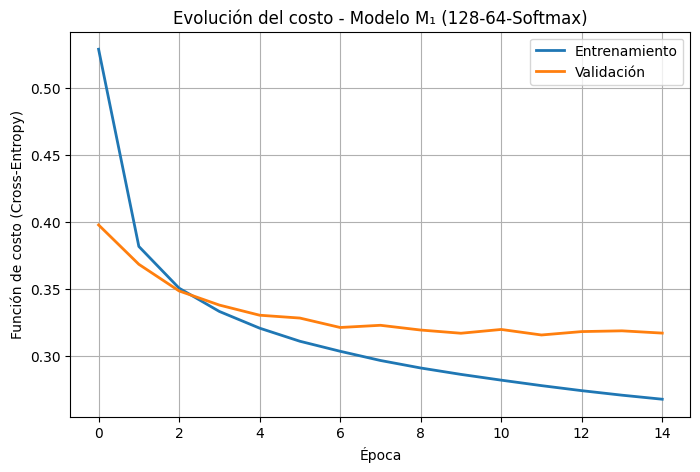

In [25]:
loss_train_m1 = loss_train
loss_val_m1  = loss_val

plt.figure(figsize=(8, 5))
plt.plot(loss_train_m1, label="Entrenamiento", linewidth=2)
plt.plot(loss_val_m1, label="Validación", linewidth=2)
plt.xlabel("Época")
plt.ylabel("Función de costo (Cross-Entropy)")
plt.title("Evolución del costo - Modelo M₁ (128-64-Softmax)")
plt.legend()
plt.grid(True)
plt.show()

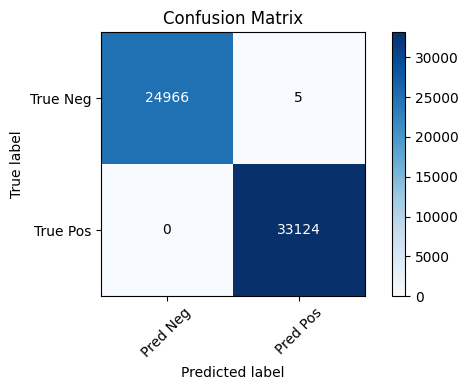

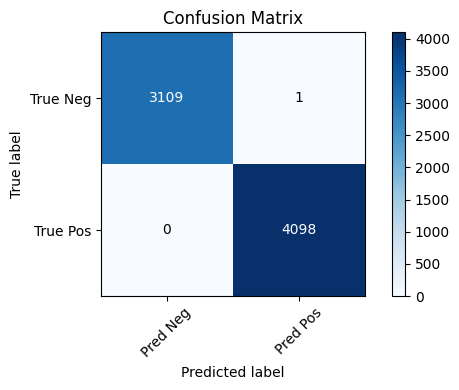

Entrenamiento:
  Accuracy:       0.9018
  Cross-Entropy:  0.2669
  F1-Score Macro: 0.8807

Validación:
  Accuracy:       0.8888
  Cross-Entropy:  0.3154
  F1-Score Macro: 0.8561


In [26]:
metrics_m1 = metrics.metrics_report(
    X_train_flat, Y_train_oh, y_train,
    X_val_flat, Y_val_oh, y_val,
    parametros_M1, num_classes
)

4. Desarrollo de una Red Neuronal con PyTorch

4.1 Modelo en Pytorch con la misma arquitectura e hiperparametros que M1 (M2)

In [ ]:
import src.pytorchmodels as torchmodels 

# Defino arquitectura e hiperparámetros M1
dims = [784, 256, 128, 47]
lr = 0.002
lambda_l2 = 1e-5
batch_size = 256
epochs = 20

# Entrenamiento
model_M2, loss_tr_M2, loss_val_M2 = torchmodels.train_pytorch_model(
    X_train_flat, y_train, X_val_flat, y_val,
    dims=dims,
    lr=lr,
    lambda_l2=lambda_l2,
    batch_size=batch_size,
    epochs=epochs,
    verbose=False
)



✅ Entrenamiento completado en 721.10s


In [ ]:
# Evaluación final
acc_val_M2 = torchmodels.evaluate_model(model_M2, X_val_flat, y_val)
print(f"Accuracy validación M2: {acc_val_M2:.4f}")

# Train loss y Val loss M2 
loss_train_m2 = loss_tr_M2
loss_val_m2  = loss_val_M2

print(f"Train loss M2 final: {loss_train_m2[-1]:.4f}")
print(f"Val loss M2 final: {loss_val_m2[-1]:.4f}")

# F1 Score Macro M2

f1_val_M2 = torchmodels.f1_score_macro(model_M2, X_val_flat, y_val)
print(f"F1-Score Macro validación M2: {f1_val_M2:.4f}")

Accuracy validación M2: 0.8845
Train loss M2 final: 0.2849
Val loss M2 final: 0.3284
F1-Score Macro validación M2: 0.8539


4.2 Busqueda de la mejor arquitectura en Pytorch (M3)

Similar a M1 entreno una grilla de modelos con distinta arquitectura y parametros para encontrar el mas optimo.

In [29]:

architectures = [
    [256, 128],          
    [512, 256, 128],
    [512, 256],
    [256, 128, 64]
]

activations = ["ReLU", "LeakyReLU", "SiLU", "GELU"]
dropouts = [0.0, 0.2, 0.3]

"""
df_results = torchmodels.search_pytorch_M3(
    X_train_flat, y_train,
    X_val_flat, y_val,
    architectures=architectures,
    activations=activations,
    dropouts=dropouts,
    lr=0.001,
    lambda_l2=1e-4,
    batch_size=256,
    epochs=10
)

display(df_results.head(10))
"""

'\ndf_results = torchmodels.search_pytorch_M3(\n    X_train_flat, y_train,\n    X_val_flat, y_val,\n    architectures=architectures,\n    activations=activations,\n    dropouts=dropouts,\n    lr=0.001,\n    lambda_l2=1e-4,\n    batch_size=256,\n    epochs=10\n)\n\ndisplay(df_results.head(10))\n'

Entrenamiento completo del mejor modelo encontrado

In [ ]:
# Defino arquitectura e hiperparámetros M3
dims = [784, 512, 256, 128, 47]
lr = 0.001
lambda_l2 = 1e-4
batch_size = 256
epochs = 20
activation = "GELU"
dropout = 0.2

# Entrenamiento
model_M3, loss_tr_M3, loss_val_M3 = torchmodels.train_pytorch_model(
    X_train_flat, y_train, X_val_flat, y_val,
    dims=dims,
    lr=lr,
    lambda_l2=lambda_l2,
    batch_size=batch_size,
    epochs=epochs,
    verbose=True,
    activation=activation,
    dropout_p=dropout
)

Época 1/20 | Train 0.6452 | Val 0.3746 | Val Acc 0.8685
Época 2/20 | Train 0.4185 | Val 0.3363 | Val Acc 0.8798
Época 3/20 | Train 0.3884 | Val 0.3212 | Val Acc 0.8845
Época 4/20 | Train 0.3727 | Val 0.3142 | Val Acc 0.8860
Época 5/20 | Train 0.3647 | Val 0.3077 | Val Acc 0.8866
Época 6/20 | Train 0.3584 | Val 0.3057 | Val Acc 0.8887
Época 7/20 | Train 0.3536 | Val 0.3042 | Val Acc 0.8885
Época 8/20 | Train 0.3503 | Val 0.3008 | Val Acc 0.8900
Época 9/20 | Train 0.3482 | Val 0.3013 | Val Acc 0.8896
Época 10/20 | Train 0.3460 | Val 0.2985 | Val Acc 0.8908
Época 11/20 | Train 0.3447 | Val 0.2976 | Val Acc 0.8901
Época 12/20 | Train 0.3443 | Val 0.2995 | Val Acc 0.8902
Época 13/20 | Train 0.3429 | Val 0.2946 | Val Acc 0.8922
Época 14/20 | Train 0.3410 | Val 0.2974 | Val Acc 0.8908
Época 15/20 | Train 0.3405 | Val 0.2946 | Val Acc 0.8924
Época 16/20 | Train 0.3394 | Val 0.2996 | Val Acc 0.8902
Época 17/20 | Train 0.3399 | Val 0.2931 | Val Acc 0.8924
Época 18/20 | Train 0.3382 | Val 0.2912 

In [31]:
# Evaluación final
acc_val_M3 = torchmodels.evaluate_model(model_M3, X_val_flat, y_val)
print(f"Accuracy validación M3: {acc_val_M3:.4f}")

loss_train_m3 = loss_tr_M3
loss_val_m3  = loss_val_M3

print(f"Train loss M3 final: {loss_train_m3[-1]:.4f}")
print(f"Val loss M3 final: {loss_val_m3[-1]:.4f}")

f1_val_M3 = torchmodels.f1_score_macro(model_M3, X_val_flat, y_val)
print(f"F1-Score Macro validación M3: {f1_val_M3:.4f}")

Accuracy validación M3: 0.8905
Train loss M3 final: 0.3371
Val loss M3 final: 0.2986
F1-Score Macro validación M3: 0.8560


4.3 Perturbacion de datos de Test con distintos niveles de ruido

In [32]:
import numpy as np
def add_gaussian_noise(X, noise_std=0.1):
    """
    Agrega ruido gaussiano (N(0, noise_std)) a las imágenes normalizadas [0,1].
    El resultado se recorta nuevamente al rango [0,1].
    
    X: array (n_samples, 28, 28) o (n_features, n_samples)
    noise_std: desviación estándar del ruido (0.0 = sin ruido)
    """
    X_noisy = X + np.random.normal(0, noise_std, X.shape)
    return np.clip(X_noisy, 0.0, 1.0)


Veamos un ejemplo rapido de como se perturban las imagenes

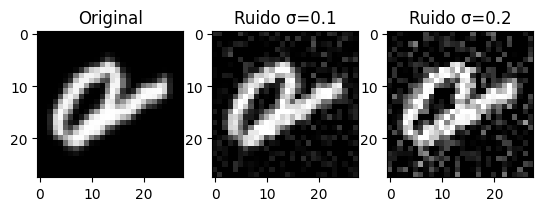

In [ ]:

idx = np.random.randint(0, len(X_test))
plt.subplot(1,3,1); plt.imshow(X_test[idx].reshape(28,28), cmap="gray"); plt.title("Original")
plt.subplot(1,3,2); plt.imshow(add_gaussian_noise(X_test[idx], 0.1).reshape(28,28), cmap="gray"); plt.title("Ruido σ=0.1")
plt.subplot(1,3,3); plt.imshow(add_gaussian_noise(X_test[idx], 0.2).reshape(28,28), cmap="gray"); plt.title("Ruido σ=0.2")
plt.show()


In [ ]:
noise_levels = [0.0, 0.05, 0.1, 0.2, 0.3]

results_noise = []

import pandas as pd

for noise in noise_levels:
    print(f"\nEvaluando con ruido σ={noise}")

    # Agrego el ruido
    X_test_noisy = add_gaussian_noise(X_test_flat, noise)

    # M1
    y_pred_M1 = models.predict(X_test_noisy, parametros_M1)
    acc_M1 = metrics.accuracy(y_test, y_pred_M1)

    # M2
    acc_M2 = torchmodels.evaluate_model(model_M2, X_test_noisy, y_test)

    # M3
    acc_M3 = torchmodels.evaluate_model(model_M3, X_test_noisy, y_test)

    results_noise.append({
        "Ruido σ": noise,
        "Accuracy M1": acc_M1,
        "Accuracy M2": acc_M2,
        "Accuracy M3": acc_M3
    })

results_noise = pd.DataFrame(results_noise)
display(results_noise)



Evaluando con ruido σ=0.0

Evaluando con ruido σ=0.05

Evaluando con ruido σ=0.1

Evaluando con ruido σ=0.2

Evaluando con ruido σ=0.3


,Ruido σ,Accuracy M1,Accuracy M2,Accuracy M3
0,0.00,0.884493,0.881009,0.887692
1,0.05,0.861826,0.877489,0.884406
2,0.10,0.722195,0.857787,0.874426
3,0.20,0.288478,0.686756,0.771234
4,0.30,0.104674,0.401453,0.535266


5) Graficos comparativos entre los modelos M0, M1, M2 y M3

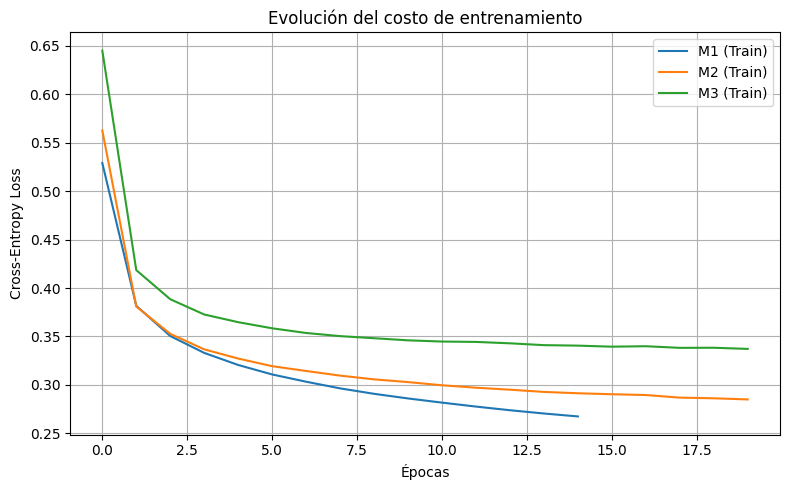

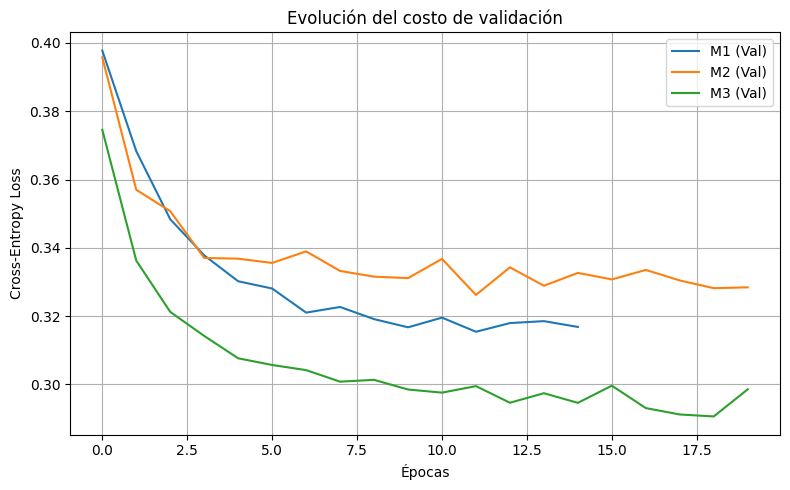

In [ ]:
import matplotlib.pyplot as plt

# --- Evolución del costo de entrenamiento ---
plt.figure(figsize=(8,5))
#plt.plot(losses_train_m0, label='M0 (Train)', linestyle='--')
plt.plot(loss_train_m1, label='M1 (Train)')
plt.plot(loss_train_m2, label='M2 (Train)')
plt.plot(loss_train_m3, label='M3 (Train)')
plt.xlabel('Épocas')
plt.ylabel('Cross-Entropy Loss')
plt.title('Evolución del costo de entrenamiento')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evolución del costo de validación 
plt.figure(figsize=(8,5))
#plt.plot(losses_val_m0, label='M0 (Val)', linestyle='--')
plt.plot(loss_val_m1, label='M1 (Val)')
plt.plot(loss_val_m2, label='M2 (Val)')
plt.plot(loss_val_m3, label='M3 (Val)')
plt.xlabel('Épocas')
plt.ylabel('Cross-Entropy Loss')
plt.title('Evolución del costo de validación')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


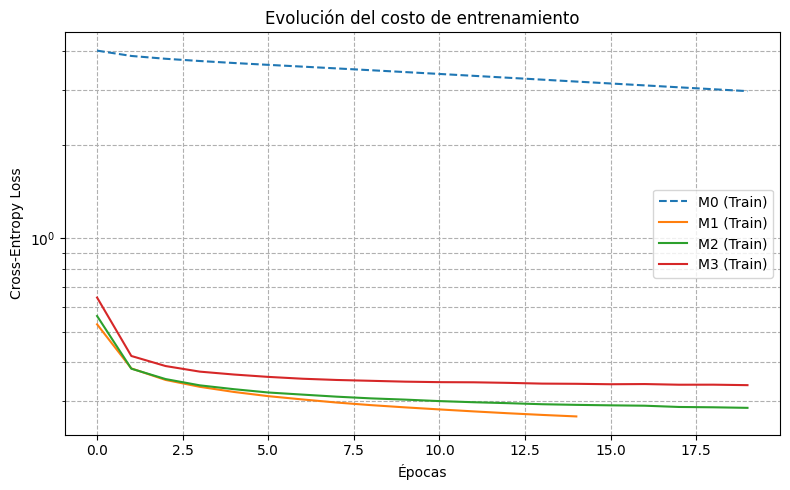

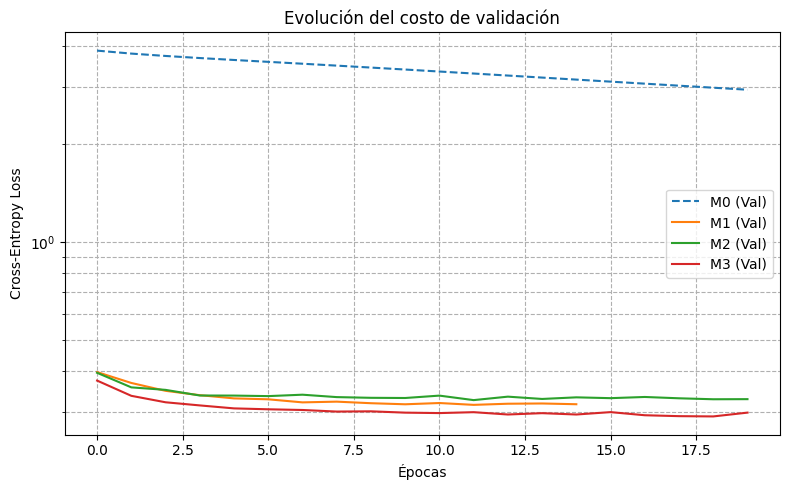

In [36]:
import matplotlib.pyplot as plt

# --- Evolución del costo de entrenamiento ---
plt.figure(figsize=(8,5))
plt.plot(losses_train_m0, label='M0 (Train)', linestyle='--')
plt.plot(loss_train_m1, label='M1 (Train)')
plt.plot(loss_train_m2, label='M2 (Train)')
plt.plot(loss_train_m3, label='M3 (Train)')
plt.xlabel('Épocas')
plt.ylabel('Cross-Entropy Loss')
plt.title('Evolución del costo de entrenamiento')
plt.yscale('log')  # escala logarítmica en el eje Y
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

# --- Evolución del costo de validación ---
plt.figure(figsize=(8,5))
plt.plot(losses_val_m0, label='M0 (Val)', linestyle='--')
plt.plot(loss_val_m1, label='M1 (Val)')
plt.plot(loss_val_m2, label='M2 (Val)')
plt.plot(loss_val_m3, label='M3 (Val)')
plt.xlabel('Épocas')
plt.ylabel('Cross-Entropy Loss')
plt.title('Evolución del costo de validación')
plt.yscale('log')  # escala logarítmica en el eje Y
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


Guardo todas las predicciones en un archivo csv

In [38]:

# === Obtener las predicciones de cada modelo ===
# (Asegurate de tener cargados X_test_flat y y_test, y los parámetros/objetos de cada modelo)

# Modelos implementados manualmente
y_pred_m0 = models.predict(X_test_flat, parametros_M0)
y_pred_m1 = models.predict(X_test_flat, parametros_M1)

# Modelos de PyTorch (M2 y M3)
# -> asumimos que tenés una función como evaluate_model o similar para obtener las predicciones
def predict_torch(model, X):
    import torch
    model.eval()
    X_t = torch.tensor(X.T, dtype=torch.float32)
    with torch.no_grad():
        y_hat = model(X_t)
        preds = torch.argmax(y_hat, dim=1).cpu().numpy()
    return preds

y_pred_m2 = predict_torch(model_M2, X_test_flat)
y_pred_m3 = predict_torch(model_M3, X_test_flat)

# === Crear DataFrame con todas las predicciones ===
pred_df = pd.DataFrame({
    "id": np.arange(len(y_pred_m0)),
    "y_true": y_test,
    "pred_M0": y_pred_m0,
    "pred_M1": y_pred_m1,
    "pred_M2": y_pred_m2,
    "pred_M3": y_pred_m3
})

# === Guardar CSV ===
pred_df.to_csv("predicciones.csv", index=False)
print("Archivo 'predicciones.csv' generado correctamente.")


Archivo 'predicciones.csv' generado correctamente.
